The purpose of this notebook is to find all of the possible decay chains based off of the data in livechart. 

In [1]:
using Unitful #https://painterqubits.github.io/Unitful.jl/stable/
#quantity * @u_str("unit abbreviation") 
using Symbolics #https://symbolics.juliasymbolics.org/dev/
#cite https://doi.org/10.48550/arXiv.2105.03949
using Latexify
using Test
#1 * @u_str("mA") is 1 milliamp
using CSV, DataFrames
#using Plots
using PlotlyJS
using Printf
using SymPy #https://docs.juliahub.com/SymPy/ 
using PDFIO
using Unzip
using Interpolations
using Downloads
using Graphs, GraphRecipes
using GraphPlot
#plotlyjs()
data_dir = ("C:\\Cross-Section-Data\\")
cross_section_dir = data_dir
parent_dir = "C:\\Users\\engin\\Documents\\GitHub\\Energy\\"
endf8_decay_dir = cross_section_dir * "ENDF_Libraries-2\\ENDF-B-VIII.0\\decay\\"
jeff33_decay_dir = cross_section_dir * "ENDF_Libraries-2\\JEFF-3.3\\decay\\"
jendl5_decay_dir = cross_section_dir * "jendl5-dec_upd5\\"

WebIO._IJuliaInit()

"C:\\Cross-Section-Data\\jendl5-dec_upd5\\"

Now I will find the average decay energies for each nuclide. For the datasets I am using, the average decay energies are all given in keV. 

In [2]:
function get_mass_name(nuclide)
    index = 1
    while (tryparse(Int64, string(nuclide[index])) != nothing && index <= length(nuclide))
        index += 1
    end
    mass = tryparse(Int64, nuclide[1:index-1])
    name =  nuclide[index:end]
    name_1 = uppercase(name[1])
    if (length(name) > 1)
        name = name_1 * name[2]
    else 
      name = name_1
    end
    return mass, name
end
element_symbols = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", 
"Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", 
"Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", 
"Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", 
"Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", 
"Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", 
"Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", 
"Po", "At", "Rn", "Fr", "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", 
"Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", 
"Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"];

Rename files in directory to be easier to parse by removing zero-padding.

In [3]:
function unzero_pad(num_str) 
    if (num_str == '0')
        return num_str
    end
    i = 1
    while i < length(num_str) && num_str[i] == '0'
        i += 1
    end
    return num_str[i : end]
end
function rename_files_in_dir(dir, cutoff_index)
    for f in readdir(dir)
        if tryparse(Int64, string(f[1])) == nothing
            mv(dir * f, dir * f[cutoff_index:end])
        end
        if f != join(unzero_pad.(split(f, "-")), "-")
            mv(dir * f, dir * join(unzero_pad.(split(f, "-")), "-"))
        end
    end
end
rename_files_in_dir(endf8_decay_dir, 12)
rename_files_in_dir(jeff33_decay_dir, 12)
rename_files_in_dir(jendl5_decay_dir, 4)

In [4]:
function get_decay_energy_from_file(file_as_arr, search_string)
    line = [l for l in file_as_arr if length(l) > length(search_string)
             && occursin(search_string, l)]
    if (length(line) > 0)
        line = String(line[1])
        line = join(split(line, search_string, keepempty = false))
        return tryparse(Float64, join(split(line, " ", keepempty = false)[1]))
    else 
        return "Energy not found"
    end
end

get_decay_energy_from_file (generic function with 1 method)

This dictionary stores what strings to look to for in the datasets to find the average energy for each decay type, and for each directory. 

In [5]:
dir_search_string_dict = Dict([
    jeff33_decay_dir => Dict(["alpha" => "ALPHA ENERGY                   =",
    "beta-minus" => "MEAN BETA- ENERGY              =","gamma" => "MEAN GAMMA ENERGY              =", 
    "x-ray" => "MEAN X-RAY ENERGY              =", "auger" => "MEAN AUGER ELECTRON ENERGY     ="
    ]),

    endf8_decay_dir => Dict(["alpha" => "Mean Alpha Energy:", 
    "beta-minus" => "Mean B- Energy:", "beta-plus" => "Mean B+ Energy:",
    "gamma" => "Mean Gamma Energy:", "auger" => "Mean CE+Auger Energy:",
    "neutron" => "Mean Neutron Energy:", "proton" => "Mean Neutron Energy:",
    "half life" => "Parent half-life:"]),

    jendl5_decay_dir => Dict(["alpha" => "Mean Alpha Energy",
    "beta-minus" => "Mean B- Energy", "gamma" => "Mean Gamma Energy",
    "neutron" => "Mean Neutron Energy", "proton" => "Mean Proton Energy",
    "auger" => "Mean CE+Auger Energy", 
    "beta-plus and electron capture" => "Mean B+/EC Energy"])  
])

Dict{String, Dict{String, String}} with 3 entries:
  "C:\\Cross-Section-Data\… => Dict("auger"=>"Mean CE+Auger Energy", "beta-plus…
  "C:\\Cross-Section-Data\… => Dict("auger"=>"Mean CE+Auger Energy:", "proton"=…
  "C:\\Cross-Section-Data\… => Dict("auger"=>"MEAN AUGER ELECTRON ENERGY     ="…

Note that based on the documentation for the livechart API, the decay type denoted "B+" also includes electron capture. 

Source: 

https://www-nds.iaea.org/relnsd/vcharthtml/api_v0_guide.html#apirad_type 

In [6]:
joules_per_keV = Rational(uconvert(@u_str("J"), 1 * @u_str("keV")) / @u_str("J"))
joules_per_MeV = 1000 * joules_per_keV
h = 6.62607015 * 10.0^(-34) / (2 * pi)
half_life_sec(gamma) = h / (joules_per_MeV * gamma)
half_life_sec(4.6)

1.4308955585889278e-22

This function is meant for particularly short half lives reported in terms of the decay width. 

In [7]:
function find_decay_info(nuclide, info, dir)
    a, el = get_mass_name(nuclide)
    el = string(el)
    z = [i for i in 1:length(element_symbols) if element_symbols[i] == el][1]
    file_name = string(z) * "-" * el * "-" * string(a) * ".dat"
    if !(file_name in readdir(dir))
        return "insufficient data"
    end
    file_path = dir * file_name
    file_as_array = split(open(f->read(f, String), file_path), "\n")
    search_string = dir_search_string_dict[dir][info]
    return get_decay_energy_from_file(file_as_array, search_string)
end

find_decay_info (generic function with 1 method)

In [8]:
small_decay_time(nuclide, dir) = string(half_life_sec(find_decay_info(nuclide, "half life", dir)))   
small_decay_time("4H", endf8_decay_dir)

"1.4308955585889278e-22"

In [9]:
function find_avg_decay_energy(nuclide, decay_type, dir)
    a, el = get_mass_name(nuclide)
    el = string(el)
    z = [i for i in 1:length(element_symbols) if element_symbols[i] == el][1]
    file_name = string(z) * "-" * el * "-" * string(a) * ".dat"
    if ! (file_name in readdir(dir))
        return "Energy not found"
    end
    file_path = dir * file_name
    file_as_array = split(open(f->read(f, String), file_path), "\n")
    search_string = dir_search_string_dict[dir][decay_type]
    return get_decay_energy_from_file(file_as_array, search_string)
end
dir_list = keys(dir_search_string_dict)
function find_avg_decay_energy(nuclide, decay_type)
    if decay_type == "electron capture"
        decay_type = "beta-plus and electron capture"
    end
    for dir in dir_list
        if decay_type in keys(dir_search_string_dict[dir])
            energy = find_avg_decay_energy(nuclide, decay_type, dir)
            if energy != "Energy not found"
                return energy
            end
        end
    end
    return "Energy not found"
end

find_avg_decay_energy (generic function with 2 methods)

Now for some examples. Again, all average decay energies are given in keV. 

In [10]:
out = find_avg_decay_energy("238U", "alpha", jeff33_decay_dir)

4187.0737

In [11]:
out = find_avg_decay_energy("3H", "beta-minus", jendl5_decay_dir)

5.69

In [12]:
avg_decay_energy = find_avg_decay_energy("8Be", "alpha", jendl5_decay_dir)

"Energy not found"

In [13]:
avg_decay_energy = find_avg_decay_energy("8Be", "alpha", jendl5_decay_dir)
if avg_decay_energy == "Energy not found"
    avg_decay_energy = find_avg_decay_energy("8Be", "alpha", jeff33_decay_dir)
end

45.95

In [14]:
find_avg_decay_energy("238U", "alpha", endf8_decay_dir)

4187.0

In [15]:
live_chart_file_name = "all_livechart_decays_and_emissions.csv"
all_live_chart_data = CSV.read(parent_dir * "ImportedData\\" * live_chart_file_name,
                        DataFrame, stringtype = String)[:,2:end]

,z,n,symbol,radius,unc_r,abundance,abundance_unc,energy_shift
,Int64,Int64,String,String,Float64?,String,String?,String?
1,0,1,Nn,-0.1149,0.0027,,missing,
2,0,4,N,,missing,,missing,
3,0,6,N,,missing,,missing,
4,1,0,H,0.8783,0.0086,99.9855,78,
5,1,1,H,2.1421,0.0088,0.0145,78,
6,1,2,H,1.7591,0.0363,,missing,
7,1,3,H,,missing,,missing,
8,1,4,H,,missing,,missing,
9,1,5,H,,missing,,missing,


In [16]:
all_live_chart_data[!, "nuclide"] = [string(all_live_chart_data[row, "z"] + 
                        all_live_chart_data[row, "n"]) * all_live_chart_data[row, "symbol"]
                        for row in 1:size(all_live_chart_data)[1]]
livechart_nuclides = unique(all_live_chart_data[!, "nuclide"])

3367-element Vector{String}:
 "1Nn"
 "4N"
 "6N"
 "1H"
 "2H"
 "3H"
 "4H"
 "5H"
 "6H"
 "7H"
 "3He"
 "4He"
 "5He"
 ⋮
 "287Mc"
 "288Mc"
 "289Mc"
 "290Mc"
 "290Lv"
 "291Lv"
 "292Lv"
 "293Lv"
 "294Lv"
 "293Ts"
 "294Ts"
 "294Og"

In [17]:
top_decay_probs = [tryparse(BigFloat, p) for p in all_live_chart_data[!,"decay_1_%"] 
                    if tryparse(Float64, p) != nothing]
decay_prob_df = DataFrame(Prob = top_decay_probs)

,Prob
,BigFloat
1,100.0
2,100.0
3,100.0
4,100.0
5,100.0
6,100.0
7,100.0
8,100.0
9,100.0


In [18]:
PlotlyJS.plot(decay_prob_df, x=:Prob, kind = "histogram", nbinsx=100, 
Layout(yaxis_type = "log"))

data: [
  "histogram with fields nbinsx, type, x, xaxis, and yaxis"
]

layout: "layout with fields legend, margin, template, xaxis, and yaxis"

In [19]:
names(all_live_chart_data)[41:end]

15-element Vector{String}:
 "sn"
 "unc_sn"
 "sp"
 "unc_sp"
 "binding"
 "unc_ba"
 "atomic_mass"
 "unc_am"
 "massexcess"
 "unc_me"
 "ENSDFpublicationcut-off"
 "ENSDFauthors"
 "Extraction_date"
 "Decay or Emission type"
 "nuclide"

In [20]:
all_live_chart_data[!, "Decay or Emission type"]

20202-element PooledArrays.PooledVector{String, UInt32, Vector{UInt32}}:
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 ⋮
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"

In [21]:
all_live_chart_data[!, "half_life_sec"]

20202-element Vector{String}:
 "613.9"
 "1.7547604425822527e-22"
 " "
 " "
 " "
 "388781328.00697345"
 " "
 "8.608258774931805e-23"
 "2.943469129492811e-22"
 "5.069307945237619e-21"
 " "
 " "
 "7.040705479496693e-22"
 ⋮
 " "
 "0.17"
 "0.22"
 "0.65"
 "0.0083"
 " "
 "0.0128"
 "0.053"
 " "
 "0.014"
 "0.051"
 "0.00058"

Very short half lives are often reported in terms of gamma. Source: 

https://www.nndc.bnl.gov/nudat3/help/glossary.jsp#halflife

In [22]:
decay_or_emission_type_dict = Dict([
    "B-" =>  "beta minus decay", "A" =>  "alpha decay", "B+" =>  "beta plus decay",
    "EC" => "auger and conversion electron"
])
function get_half_life(nuclide, decay_type)
    if decay_type == "EC+B+" 
        decay_type = "B+"
    end
    if decay_type in keys(decay_or_emission_type_dict)
        decay_type_long = decay_or_emission_type_dict[decay_type]
        row = [row for row in 1:size(all_live_chart_data)[1]
                if ((all_live_chart_data[row, "nuclide"] ==  nuclide) && 
                (decay_type_long == all_live_chart_data[row, "Decay or Emission type"])
                )][1]
        return all_live_chart_data[row, "half_life_sec"]
    end
    if decay_type in values(decay_or_emission_type_dict)
        row = [row for row in 1:size(all_live_chart_data)[1]
                if (all_live_chart_data[row, "nuclide"] ==  nuclide && 
                decay_type == all_live_chart_data[row, "Decay or Emission type"])][1]
        return all_live_chart_data[row, "half_life_sec"]
    end
    if decay_type in keys(livechart_abbreviation_decay_types)
        row = 1
        while (row < size(all_live_chart_data)[1] && 
                all_live_chart_data[row, "nuclide"] !=  nuclide)
            row += 1
        end
        half_life =  all_live_chart_data[row, "half_life_sec"]
        if split(half_life, "second", keepempty = false)[1] == " "
            try 
                return small_decay_time(nuclide, endf8_decay_dir)
            catch
                return "insufficient data"
            end
        end
        return half_life
    end
    return decay_type * " not accounted for "
end

get_half_life (generic function with 1 method)

In [23]:
split(" second", "second", keepempty =false)

1-element Vector{SubString{String}}:
 " "

In [24]:
all_live_chart_data[!, "nuclide"] 

20202-element Vector{String}:
 "1Nn"
 "4N"
 "6N"
 "1H"
 "2H"
 "3H"
 "4H"
 "5H"
 "6H"
 "7H"
 "3He"
 "4He"
 "5He"
 ⋮
 "287Mc"
 "288Mc"
 "289Mc"
 "290Mc"
 "290Lv"
 "291Lv"
 "292Lv"
 "293Lv"
 "294Lv"
 "293Ts"
 "294Ts"
 "294Og"

In [25]:
all_live_chart_data[!, "Decay or Emission type"]

20202-element PooledArrays.PooledVector{String, UInt32, Vector{UInt32}}:
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 "beta minus decay"
 ⋮
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"
 "x ray emission"

In [26]:
decay_type = "B-"
nuclide = "3H"
decay_type_long = decay_or_emission_type_dict[decay_type]


"beta minus decay"

In [27]:
all_live_chart_data[6, "Decay or Emission type"]

"beta minus decay"

In [28]:
function get_daughter_nuclide(parent, decay_type)
    if decay_type == "gamma"
        return parent
    end
    mass, el = get_mass_name(parent)
    el_index = [i for i in 1:length(element_symbols)
                if element_symbols[i] == string(el)][1]
    if decay_type == "alpha" || decay_type == "A"
        return string(mass - 4) * element_symbols[el_index - 2]
    end
    if decay_type == "beta-minus" || decay_type == "B-"
        return string(mass) * element_symbols[el_index + 1]
    end
    if decay_type == "beta-plus" || decay_type == "B+" ||  decay_type == "EC+B+"
        return string(mass) * element_symbols[el_index - 1]
    end
    if decay_type == "neutron" || decay_type == "N"
        return string(mass-1) * el
    end
    if decay_type == "proton" || decay_type == "P"
        return string(mass-1) * element_symbols[el_index - 1]
    end
    if decay_type == "double neutron" || decay_type == "2N"
        return string(mass-2) * el
    end
    if decay_type == "double proton" || decay_type == "2P"
        return string(mass-2) * element_symbols[el_index - 2]
    end
    if decay_type == "double neutron" || decay_type == "2N"
        return string(mass-2) * element_symbols[el_index - 1]
    end
    return decay_type * " not yet accounted for"
end

get_daughter_nuclide (generic function with 1 method)

In [29]:
livechart_abbreviation_decay_types = Dict([
    "A" => "alpha", "B-" => "beta-minus", "B+" => "beta-plus", 
    "N" => "neutron", "P" => "proton", "EC+B+" => "beta-plus and electron capture",
    "EC" => "electron capture"
])
unique(all_live_chart_data[!,"decay_1"])

21-element Vector{String}:
 "B-"
 " "
 "N"
 "2N"
 "P"
 "A"
 "EC"
 "EC+B+"
 "2P"
 "B+P"
 "B-N"
 "B-2N"
 "B+"
 "2B-"
 "ECP+EC2P"
 "2EC"
 "IT"
 "ECP"
 "2B+"
 "SF"
 "ECSF"

The function named decay returns all vector describing all of the possible decay paths for a given parent nuclide. Each decay path in the vector includes the decay type, the probability of that decay type occurring as a percentage, and what daughter isotope will be produced. 

In [30]:
function decay(parent)
    if occursin("not yet accounted for", parent)
        return parent
    end
    row = 1
    #mass, elem = 
    while (row < size(all_live_chart_data)[1]
        && all_live_chart_data[row, "nuclide"] != parent)
        row += 1
    end 
    decay_types = (all_live_chart_data[row, "decay_1"], all_live_chart_data[row, "decay_2"],
                    all_live_chart_data[row, "decay_3"])
    if decay_types[1] == " "
        return "stable"
    end
    decay_percents =  (all_live_chart_data[row, "decay_1_%"], all_live_chart_data[row, "decay_2_%"],
                        all_live_chart_data[row, "decay_3_%"])
    direct_daughters = [get_daughter_nuclide(parent, decay_type) 
                        for decay_type in decay_types if decay_type != " "]
    decay_energies = Vector{Any}(undef, length(direct_daughters))
    half_lives = Vector{Any}(undef, length(direct_daughters))
    for i in 1:length(direct_daughters)
        decay_type = decay_types[i] 
        half_lives[i] = get_half_life(parent, decay_type)
        if !occursin("not accounted for ", half_lives[i])
            half_lives[i] = half_lives[i] * "seconds"
        end
        if decay_type in keys(livechart_abbreviation_decay_types)
            decay_energies[i] = string(find_avg_decay_energy(parent, 
                        livechart_abbreviation_decay_types[decay_type])) * "keV"
        else 
            decay_energies[i] = decay_type * " not yet accounted for"
        end
    end
    return [(decay_types[i], decay_percents[i] * "%", decay_energies[i],
            half_lives[i], direct_daughters[i])
            for i in 1:length(direct_daughters)]
end
chain = decay("238U")

2-element Vector{NTuple{5, String}}:
 ("A", "100%", "4187.13keV", "1.4099634525447706e17seconds", "234Th")
 ("SF", "0.0000545%", "SF not yet accounted for", "SF not accounted for ", "SF not yet accounted for")

In [31]:
decay("238Pu")

2-element Vector{NTuple{5, String}}:
 ("A", "100%", "5486.38keV", "2767542407.9717183seconds", "234U")
 ("SF", "0.00000019%", "SF not yet accounted for", "SF not accounted for ", "SF not yet accounted for")

Each decay route will be stored as its own string of the form isotope,decay type,probability,average energy released, daughter isotope. 

For example,

"3H,B-,100%,5.69keV,3He"

 means that 100% of tritium decays are beta-minus decay, and on average the produced beta particles will have a kinetic energy of 5.69 keV.

In [32]:
function add_to_decay_route_string(parent)
    if occursin(",", parent) 
        if decay_route_complete(parent)
            return parent
        end
        decay_route = parent
        parent = split(parent, ",")[end]
        decay_result = decay(parent)
        if typeof(decay_result) == String
            return [decay_route * "," * decay_result]
        end
        return [decay_route * "," * join(d, ",") for d in decay(parent)]
    end
    decay_result = decay(parent)
    if typeof(decay_result) == String
        return [parent * "," * decay_result]
    end
    return [parent * "," * join(d, ",") for d in decay(parent)]
end

add_to_decay_route_string (generic function with 1 method)

In [33]:
decay_route_complete(decay_route) = (occursin("not yet accounted for", decay_route)
                                    ||occursin("stable", decay_route))
all_decay_routes_complete(decay_routes) = (sum([
    decay_route_complete(decay_route) for decay_route in decay_routes]) 
    == length(decay_routes))

all_decay_routes_complete (generic function with 1 method)

In [34]:
decay_route_strs = [add_to_decay_route_string("238U")]
!all_decay_routes_complete(add_to_decay_route_string("238U"))

true

Now I will calculate the power time series for each decay chain. 

I derived the decay rate of the n-th generation nuclide in a decay chain here:

https://www.overleaf.com/project/627613def6b848465d85e5bb

https://github.com/MarcosP7635/Math-for-Energy/blob/main/main.tex

file:///C:/Users/engin/Downloads/Math_for_Energy(4).pdf 

In [35]:
factor(t, e_folding_time) = 1 - exp(t / -e_folding_time)
a_prod(e_folding_times, t) = prod([factor(t, e_folding_times[k])
                                   for k in 2:length(e_folding_times)])
r(e_fold_times, t) = (a_prod(e_fold_times, t) * exp(t / -e_fold_times[1])
                                   / e_fold_times[1])
λ_0, λ_1, λ_2, t = @variables λ_0, λ_1, λ_2, t
expected_output = (1 - exp(t / -λ_1)) * (1 - exp(t / -λ_2)) * exp(t / -λ_0) / λ_0

((1 - exp(t / (-λ_1)))*(1 - exp(t / (-λ_2)))*exp(t / (-λ_0))) / λ_0

In [36]:
e_folding_times = [λ_0, λ_1, λ_2]
r(e_folding_times, t)
Test.@test r(e_folding_times, t) - expected_output == 0

Test Passed
  Expression: r(e_folding_times, t) - expected_output == 0
   Evaluated: 0 == 0

Avogrado's Number

In [37]:
N_A = 6.02214076e23
conversion_factor = Rational(joules_per_keV * N_A)

6475021031458043//67108864

Now we calculate the power in watts

In [38]:
power_per_mole(decay_rate, decay_energy) = decay_rate * decay_energy * conversion_factor

power_per_mole (generic function with 1 method)

In [39]:
decay("238Pu")

2-element Vector{NTuple{5, String}}:
 ("A", "100%", "5486.38keV", "2767542407.9717183seconds", "234U")
 ("SF", "0.00000019%", "SF not yet accounted for", "SF not accounted for ", "SF not yet accounted for")

In [40]:
is_last_step(step) = ("stable" in step || 
                    any([occursin(" ", part) for part in step]) || 
                    any([occursin("nothing", part) for part in step]))
function add_to_dict(dict, isotope, is_parent)
    if isotope == "stable"
        return dict
    end
    key = isotope
    old = dict
    new_decay = decay(isotope)
    if is_parent
        key = "Parent"
    end
    if new_decay == "stable"
        dict[key] = Dict(["Daughters" => ["stable"]])
        return copy(dict)
    end
    last_step = [is_last_step(decay_step) for decay_step in new_decay]
    if all(last_step)
        return copy(dict)
    end
    probabilities = [parse(Float64, new_decay[index][2][1:end-1]) / 100 
                            for index in 1:length(new_decay)
                            if length(new_decay[index]) > 2 && !last_step[index]]
    daughters = [new_decay[index][end] for index in 1:length(new_decay)
                    if !last_step[index]]
    energies =  [parse(Float64, new_decay[index][3][1:end-3])
                    for index in 1:length(new_decay)
                    if length(new_decay[index]) > 2 && !last_step[index]]
    e_folding_times =  [parse(Float64, new_decay[index][4][1:end-7]) / log(2)
                        for index in 1:length(new_decay)
                        if length(new_decay[index]) > 3 && !last_step[index]]
    dict[key] = Dict(["Energies (keV)" => energies, "e-fold (seconds)" => e_folding_times, 
                            "Probabilities" => probabilities, "Daughters" => daughters])
    return copy(dict)
end
function make_nested_decay_dict(isotope)
    decay_dict = Dict([])
    add_to_dict(decay_dict, isotope, true)
    if decay_dict == Dict([])
        decay_dict[isotope] = "insufficient data"
        return decay_dict
    end
    for isotope in decay_dict["Parent"]["Daughters"]
        add_to_dict(decay_dict, isotope, false)
    end
    old_dict = Dict([])
    while old_dict != decay_dict
        old_dict = copy(decay_dict)
        known_isotopes = [key for key in keys(decay_dict) if key != "Parent"]
        for key in known_isotopes
            for isotope in decay_dict[key]["Daughters"]
                add_to_dict(decay_dict, isotope, false)
            end
        end
    end
    return decay_dict
end
make_nested_decay_dict("238Pu")

Dict{Any, Any} with 18 entries:
  "206Pb"  => Dict("Daughters"=>["stable"])
  "218Rn"  => Dict{String, Vector}("e-fold (seconds)"=>[0.048691], "Probabiliti…
  "222Rn"  => Dict{String, Vector}("e-fold (seconds)"=>[4.76595e5], "Probabilit…
  "210Tl"  => Dict{String, Vector}("e-fold (seconds)"=>[112.53], "Probabilities…
  "206Hg"  => Dict{String, Vector}("e-fold (seconds)"=>[720.193], "Probabilitie…
  "Parent" => Dict{String, Vector}("e-fold (seconds)"=>[3.99272e9], "Probabilit…
  "218Po"  => Dict{String, Vector}("e-fold (seconds)"=>[268.082, 268.082], "Pro…
  "226Ra"  => Dict{String, Vector}("e-fold (seconds)"=>[7.28432e10], "Probabili…
  "206Tl"  => Dict{String, Vector}("e-fold (seconds)"=>[363.732], "Probabilitie…
  "234U"   => Dict{String, Vector}("e-fold (seconds)"=>[1.11769e13], "Probabili…
  "230Th"  => Dict{String, Vector}("e-fold (seconds)"=>[3.43274e12], "Probabili…
  "218At"  => Dict{String, Vector}("e-fold (seconds)"=>[1.84665, 1.84665], "Pro…
  "214Bi"  => Dict{String, Vector

In [41]:
decay_dict = Dict([])
for nuclide in livechart_nuclides
    try
        add_to_dict(decay_dict, nuclide, false)
    catch
        println("Was not able to automatically include ", nuclide)
    end
end
decay_dict["1Nn"] = Dict(["Energies (keV)" =>[301.4], "e-fold (seconds)" => [613.9 / log(2)], 
                            "Probabilities" =>[1], "Daughters" => ["1H"]])
decay_dict

Was not able to automatically include 1Nn


Dict{Any, Any} with 2733 entries:
  "113Sn" => Dict{String, Vector}("e-fold (seconds)"=>[1.43458e7], "Probabiliti…
  "243Cf" => Dict{String, Vector}("e-fold (seconds)"=>[926.21, 926.21], "Probab…
  "168Eu" => Dict{String, Vector}("e-fold (seconds)"=>[0.288539], "Probabilitie…
  "160Dy" => Dict("Daughters"=>["stable"])
  "162Sm" => Dict{String, Vector}("e-fold (seconds)"=>[3.46247], "Probabilities…
  "57V"   => Dict{String, Vector}("e-fold (seconds)"=>[0.461662], "Probabilitie…
  "208Po" => Dict{String, Vector}("e-fold (seconds)"=>[1.31937e8, 1.31937e8], "…
  "174Ir" => Dict{String, Vector}("e-fold (seconds)"=>[11.3973], "Probabilities…
  "144Gd" => Dict{String, Vector}("e-fold (seconds)"=>[386.931], "Probabilities…
  "80Sr"  => Dict{String, Vector}("e-fold (seconds)"=>[9201.51], "Probabilities…
  "33Ar"  => Dict{String, Vector}("e-fold (seconds)"=>[0.249586], "Probabilitie…
  "108In" => Dict{String, Vector}("e-fold (seconds)"=>[5020.58], "Probabilities…
  "252No" => Dict{String, Vector

In [42]:
function make_decay_chain(isotope)
    decay_chain = Dict([])
    decay_chain["Parent"] = decay_dict[isotope]
    for isotope in decay_chain["Parent"]["Daughters"]
        if isotope == "stable"
            return decay_chain
        end
        if isotope in keys(decay_dict)
            decay_chain[isotope] = decay_dict[isotope]
        end
    end
    old_dict = Dict([])
    while old_dict != decay_chain
        old_dict = copy(decay_chain)
        known_isotopes = [key for key in keys(decay_chain) if key != "Parent"]
        for key in known_isotopes
            for isotope in decay_dict[key]["Daughters"]
                if isotope in keys(decay_dict)
                    if decay_dict[isotope] != "stable"
                        decay_chain[isotope] = decay_dict[isotope]
                    end
                end
            end
        end
    end
    return decay_chain
end
decay_chains = Dict([])
for nuclide in livechart_nuclides[2:end]
    if nuclide in keys(decay_dict)
        decay_chains[nuclide] = make_decay_chain(nuclide)
    end
end
decay_chains

Dict{Any, Any} with 2732 entries:
  "113Sn" => Dict{Any, Any}("113In"=>Dict("Daughters"=>["stable"]), "Parent"=>D…
  "243Cf" => Dict{Any, Any}("227Ac"=>Dict{String, Vector}("e-fold (seconds)"=>[…
  "168Eu" => Dict{Any, Any}("168Er"=>Dict("Daughters"=>["stable"]), "168Dy"=>Di…
  "160Dy" => Dict{Any, Any}("Parent"=>Dict("Daughters"=>["stable"]))
  "162Sm" => Dict{Any, Any}("162Gd"=>Dict{String, Vector}("e-fold (seconds)"=>[…
  "57V"   => Dict{Any, Any}("57Mn"=>Dict{String, Vector}("e-fold (seconds)"=>[1…
  "208Po" => Dict{Any, Any}("208Bi"=>Dict{String, Vector}("e-fold (seconds)"=>[…
  "174Ir" => Dict{Any, Any}("170Re"=>Dict{String, Vector}("e-fold (seconds)"=>[…
  "144Gd" => Dict{Any, Any}("144Eu"=>Dict{String, Vector}("e-fold (seconds)"=>[…
  "80Sr"  => Dict{Any, Any}("80Kr"=>Dict("Daughters"=>["stable"]), "80Rb"=>Dict…
  "33Ar"  => Dict{Any, Any}("33Cl"=>Dict{String, Vector}("e-fold (seconds)"=>[3…
  "108In" => Dict{Any, Any}("108Cd"=>Dict("Daughters"=>["stable"]), "Parent"=>D…
  "252

In [43]:
decay_chains["238Pu"]

Dict{Any, Any} with 18 entries:
  "206Pb"  => Dict("Daughters"=>["stable"])
  "218Rn"  => Dict{String, Vector}("e-fold (seconds)"=>[0.048691], "Probabiliti…
  "222Rn"  => Dict{String, Vector}("e-fold (seconds)"=>[4.76595e5], "Probabilit…
  "210Tl"  => Dict{String, Vector}("e-fold (seconds)"=>[112.53], "Probabilities…
  "206Hg"  => Dict{String, Vector}("e-fold (seconds)"=>[720.193], "Probabilitie…
  "Parent" => Dict{String, Vector}("e-fold (seconds)"=>[3.99272e9], "Probabilit…
  "218Po"  => Dict{String, Vector}("e-fold (seconds)"=>[268.082, 268.082], "Pro…
  "226Ra"  => Dict{String, Vector}("e-fold (seconds)"=>[7.28432e10], "Probabili…
  "206Tl"  => Dict{String, Vector}("e-fold (seconds)"=>[363.732], "Probabilitie…
  "234U"   => Dict{String, Vector}("e-fold (seconds)"=>[1.11769e13], "Probabili…
  "230Th"  => Dict{String, Vector}("e-fold (seconds)"=>[3.43274e12], "Probabili…
  "218At"  => Dict{String, Vector}("e-fold (seconds)"=>[1.84665, 1.84665], "Pro…
  "214Bi"  => Dict{String, Vector

In [44]:
function get_index(element, list)
    l = length(list)
    i = 1
    while i < l && list[i] != element
        i += 1
    end
    return i
end

get_index (generic function with 1 method)

In [45]:
function make_decay_chain_graph(ancestor)
    chain = decay_chains[ancestor]
    isotope_numbers = [i for i in keys(chain) if i != "Parent"]
    push!(isotope_numbers, ancestor)
    push!(isotope_numbers, "stable")
    edges = [Edge(get_index(ancestor, isotope_numbers),
                    get_index(daughter, isotope_numbers)) 
            for daughter in chain["Parent"]["Daughters"]]
    for parent in keys(chain)
        if "Daughters" in keys(chain[parent]) && parent != "Parent"
            for daughter in chain[parent]["Daughters"]
                push!(edges, Edge(get_index(parent, isotope_numbers), 
                            get_index(daughter, isotope_numbers)))
            end
        end
    end
    g = SimpleDiGraph(edges)
    nodelabel = [isotope_numbers[i] for i in Graphs.vertices(g)]
    return g, nodelabel
end
make_decay_chain_graph("238Pu")

(SimpleDiGraph{Int64}(23, [[19], [14], [6], [13], [8], [11, 16], [3], [1], [10], [7], [2, 12], [4, 14], [5, 17], [13], [1], [12], [8, 15], [9], Int64[]], [[8, 15], [11], [7], [12], [13], [3], [10], [5, 17], [18], [9], [6], [11, 16], [4, 14], [2, 12], [17], [6], [13], Int64[], [1]]), ["206Pb", "218Rn", "222Rn", "210Tl", "206Hg", "218Po", "226Ra", "206Tl", "234U", "230Th", "218At", "214Bi", "210Pb", "214Po", "210Po", "214Pb", "210Bi", "238Pu", "stable"])

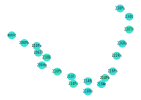

In [46]:
function display_decay_chain(ancestor)
    g, nodelabel = make_decay_chain_graph(ancestor)
    layout=(args...)->spring_layout(args...; C=3)
    return gplot(g, layout=layout, nodelabel=nodelabel, NODELABELSIZE=2.75,
                NODESIZE=.07, EDGELINEWIDTH=.1, arrowlengthfrac=0.05)
end
display_decay_chain("238Pu")

I can just traverse the decay chain using the Daughters key in the subdictionary for each Parent key :) 

So the dictionary representation in decay_chains should be sufficient!

It'll be easiest to just recurse everytime there are multiple decay modes. However, there should NEVER be a nested vector from this function. 

This will be easiest if I write a function that finds the ancestors of a given isotope. 

In [47]:
decay_chains["4H"]["Parent"]

Dict{String, Vector} with 4 entries:
  "e-fold (seconds)" => [2.06435e-22]
  "Probabilities"    => [1.0]
  "Energies (keV)"   => [2880.39]
  "Daughters"        => ["3H"]

Now I will programmatically retrieve the probabilities of each decay necessary for a given daughter isotope to form in a given decay chain.

In [48]:
function get_decay_index(parent, daughter, complete_chain)
    if daughter in complete_chain["Parent"]["Daughters"]
        return get_index(daughter, complete_chain["Parent"]["Daughters"])        
    else
        return get_index(daughter, complete_chain[parent]["Daughters"])
    end
end

function energy_per_mole_info(isotope, ancestor)
    chain = decay_chains[ancestor]
    decay_probs, ancestors = [], []
    if isotope == ancestor
        decay_probs = [[x] for x in chain["Parent"]["Probabilities"]]
        return decay_probs
    end
    for key in keys(chain)
        if isotope in chain[key]["Daughters"]
            decay_index = get_decay_index(key, isotope, chain)
            push!(decay_probs, [chain[key]["Probabilities"][decay_index]])
            push!(ancestors, [key])
        end
    end
    if ancestors == [["Parent"]]
        return decay_probs
    end
    #The parent isn't the beginning of the decay chain so recurse
    original_length = length(ancestors)
    for index in 1:original_length
        #cycle through each way isotope can be produced directly
        parent = ancestors[index][1]
        list_of_probs = energy_per_mole_info(parent, ancestor) 
        original_probs = copy(decay_probs[index])
        decay_probs[index] = vcat(original_probs, list_of_probs[1])
        if length(list_of_probs) > 1
            for path_index in 2:length(list_of_probs)
                push!(decay_probs, vcat(original_probs, list_of_probs[path_index]))
            end
        end
    end
    return decay_probs
end
info = energy_per_mole_info("3He", "4H")

1-element Vector{Any}:
 [1.0, 1.0]

Now to test the information retrieval symbolically

In [49]:
example_decay_dict = Dict([])
E_0, E_1, E_2, p_0, p_1, p_2, t = @variables E_0, E_1, E_2, p_0, p_1, p_2, t
E_1b, p_1b, λ_1b = @variables E_1b, p_1b, λ_1b
example_decay_dict["Parent"] = Dict(["Energies (keV)" => [E_0], "e-fold (seconds)" => [λ_0], 
                            "Probabilities" => [p_0], "Daughters" => ["daughter0"]])
example_decay_dict["daughter0"] = Dict(["Energies (keV)" => [E_1, E_1b], 
                                "e-fold (seconds)" => [λ_1, λ_1b], 
                                "Probabilities" => [p_1, p_1b], 
                                "Daughters" => ["daughter1", "daughter1b"]])
example_decay_dict["daughter1"] = Dict(["Energies (keV)" => [E_2], "e-fold (seconds)" => [λ_2], 
                                "Probabilities" => [p_2], "Daughters" => ["daughter2"]])
example_decay_dict
decay_chains["test"] = example_decay_dict
decay_chains["test"]

Dict{Any, Any} with 3 entries:
  "daughter1" => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_2], "Probabilit…
  "Parent"    => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_0], "Probabilit…
  "daughter0" => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_1, λ_1b], "Prob…

In [50]:
Test.@test energy_per_mole_info("daughter1b", "test") - [[p_1b, p_0]] == [[0,0]]

Test Passed
  Expression: energy_per_mole_info("daughter1b", "test") - [[p_1b, p_0]] == [[0, 0]]
   Evaluated: Vector{Num}[[0, 0]] == [[0, 0]]

energy_of_entire_decay_chain() returns the energy produced by given isotope and all of its resulting daughter isotopes. Note that this energy is the average energy released in keV/atom of given isotope.  

In [51]:
function energy_per_mole(isotope, ancestor, final_decay)
    nested_decay_prob = energy_per_mole_info(isotope, ancestor)
    final_probs = final_decay["Probabilities"]
    energy = 0
    if isotope == ancestor
        for i in 1:length(final_probs)
            energy += final_probs[i] * final_decay["Energies (keV)"][i]
        end
        return energy
    end  
    for path in 1:length(nested_decay_prob)
        decay_probs = [nested_decay_prob[path][i] 
                        for i in length(nested_decay_prob[path]):-1:1]
        for final_decay_index in 1:length(final_probs)
            total_prob = prod(decay_probs) * final_probs[final_decay_index]
            energy += total_prob * final_decay["Energies (keV)"][final_decay_index]
        end
    end
    return energy
end

function energy_of_entire_decay_chain(ancestor)
    chain = decay_chains[ancestor]
    energy = 0
    isotope_list = [key for key in keys(chain) 
                    if !(key == "Parent" || is_last_step(chain[key]["Daughters"]))]
    push!(isotope_list, ancestor)
    for isotope in isotope_list
        if ancestor == isotope
            final_decay = chain["Parent"]
        else
            final_decay = chain[isotope]
        end
        energy += energy_per_mole(isotope, ancestor, final_decay)
    end
    return energy
end

energy_of_entire_decay_chain (generic function with 1 method)

Now to symbolically verify that the above functions work correctly. 

In [52]:
expected_output = p_0*E_0 + p_0*p_1*E_1 + p_0*p_1*p_2*E_2 + p_0*p_1b*E_1b

E_0*p_0 + E_1*p_0*p_1 + E_1b*p_0*p_1b + E_2*p_0*p_1*p_2

In [53]:
Test.@test Symbolics.simplify(energy_of_entire_decay_chain("test") 
    - expected_output) == 0

Test Passed
  Expression: Symbolics.simplify(energy_of_entire_decay_chain("test") - expected_output) == 0
   Evaluated: 0 == 0

In [54]:
pop!(decay_chains, "test")
decay_chains["63Ni"]

Dict{Any, Any} with 2 entries:
  "63Cu"   => Dict("Daughters"=>["stable"])
  "Parent" => Dict{String, Vector}("e-fold (seconds)"=>[4.60733e9], "Probabilit…

In [211]:
total_energy_dict = Dict([])
for ancestor in keys(decay_chains)
    if !is_last_step(decay_chains[ancestor]["Parent"]["Daughters"])
        total_energy_dict[ancestor] = energy_of_entire_decay_chain(ancestor)
    end
end
total_energy_dict

Dict{Any, Any} with 2457 entries:
  "113Sn" => 0.0
  "243Cf" => 46035.7
  "230Pu" => 30527.6
  "106Nb" => 7402.24
  "168Eu" => 5406.46
  "18Ne"  => 1740.79
  "75Cu"  => 5002.01
  "162Sm" => 2865.73
  "57V"   => 6600.73
  "208Po" => 5114.5
  "222Pa" => 4227.89
  "174Ir" => 18.6516
  "167Re" => 883.508
  "21F"   => 2354.19
  "144Gd" => 2056.45
  "56Ni"  => 121.041
  "80Sr"  => 2073.78
  "118In" => 1879.0
  "188Bi" => 7220.76
  "175Pt" => 4420.73
  "39Ti"  => 329.23
  "59Zn"  => 5315.07
  "129La" => 718.533
  "33Ar"  => 5889.04
  "52K"   => 12431.2
  ⋮       => ⋮

In [212]:
largest_energy = maximum(values(total_energy_dict))

72241.86915475494

In [213]:
[(ancestor, total_energy_dict[ancestor]) 
for ancestor in keys(total_energy_dict)
if total_energy_dict[ancestor] > 3 * 10^4]

143-element Vector{Tuple{String, Float64}}:
 ("243Cf", 46035.684507775644)
 ("230Pu", 30527.6)
 ("266Bh", 45007.36335379556)
 ("252No", 41414.44812944193)
 ("254Es", 55884.98067117996)
 ("242Np", 50161.097183793514)
 ("228Th", 31169.467181999997)
 ("246Cf", 58272.42718379351)
 ("232Np", 36471.72144550528)
 ("251Cf", 64085.34469982409)
 ("243Bk", 53368.23570510409)
 ("234U", 39936.577183793524)
 ("228Ac", 31520.097182)
 ⋮
 ("249Fm", 34328.55572083608)
 ("238Th", 46347.75718379352)
 ("255Fm", 71139.56469982408)
 ("262Db", 45007.36335379556)
 ("238Pa", 45781.08718379352)
 ("240Np", 45506.957182)
 ("231Ac", 38635.274699824105)
 ("237Np", 34388.055962305916)
 ("251No", 36329.16422132854)
 ("249Cm", 51393.08828326399)
 ("230Fr", 37873.007183793525)
 ("229Fr", 47114.85192461183)

In [214]:
df = DataFrame(total_energy_dict)

,100Ag,100Cd,100In,100Kr,100Nb,100Rb,100Rh,100Sn,100Sr
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1055.3,1518.64,2857.78,17239.1,2414.0,13269.1,40.92,2857.78,9001.1


In [216]:
CSV.write(parent_dir * "ExportedData\\total_energies_of_decay_chains.csv", df)

"C:\\Users\\engin\\Documents\\GitHub\\Energy\\ExportedData\\total_energies_of_decay_chains.csv"

power_per_mole_info() returns an array of 3 nested vectors: the e-folding times of the decay of each isotope that directly or indirectly contributes to the abundance of a given isotope in a given decay chain, the probability of the relevant decay mode of each isotope that directly or indirectly contributes to the abundance of a given isotope in a given decay chain, and the name  of each isotope that directly or indirectly contributes to the abundance of a given isotope in a given decay chain.

It returns an array of 3 nested vectors because there may be multiple ways an isotope may form in a given decay chain, due to the fact that isotopes can have multiple decay modes. 

In [48]:
function power_per_mole_info(isotope, ancestor)
    chain = decay_chains[ancestor]
    e_fold_times, decay_probs, ancestors = [], [], []
    if isotope == ancestor
        e_fold_times = [[x] for x in chain["Parent"]["e-fold (seconds)"]]
        decay_probs = [[x] for x in chain["Parent"]["Probabilities"]]
        return e_fold_times, decay_probs, [[ancestor]]
    end
    for key in keys(chain)
        if isotope in chain[key]["Daughters"]
            decay_index = get_decay_index(key, isotope, chain)
            push!(e_fold_times, [chain[key]["e-fold (seconds)"][decay_index]])
            push!(decay_probs, [chain[key]["Probabilities"][decay_index]])
            push!(ancestors, [key])
        end
    end
    if ancestors == [["Parent"]]
        return e_fold_times, decay_probs, [[ancestor]]
    end
    #The parent isn't the beginning of the decay chain so recurse
    original_length = length(ancestors)
    for index in 1:original_length
        #cycle through each way isotope can be produced directly
        parent = ancestors[index][1]
        list_of_times, list_of_probs, list_of_paths = power_per_mole_info(parent, ancestor) 
        original_ancestors = copy(ancestors[index])
        original_times = copy(e_fold_times[index])
        original_probs = copy(decay_probs[index])
        ancestors[index] = vcat(original_ancestors, list_of_paths[1])
        e_fold_times[index] = vcat(original_times, list_of_times[1])
        decay_probs[index] = vcat(original_probs, list_of_probs[1])
        if length(list_of_paths) > 1
            for path_index in 2:length(list_of_paths)
                push!(ancestors, vcat(original_ancestors, list_of_paths[path_index]))
                push!(e_fold_times, vcat(original_times, list_of_times[path_index]))
                push!(decay_probs, vcat(original_probs, list_of_probs[path_index]))
            end
        end
    end
    return e_fold_times, decay_probs, ancestors
end
info = power_per_mole_info("206Pb", "210Pb")

(Any[[1.7248409479703624e7, 624740.0438824259, 1.0106998575252168e9], [363.73227370892545, 624740.0438824259, 1.0106998575252168e9], [363.73227370892545, 720.1933644117705, 1.0106998575252168e9]], Any[[1.0, 1.0, 1.0], [1.0, 1.32e-6, 1.0], [1.0, 1.0, 1.9e-8]], Any[["210Po", "210Bi", "210Pb"], ["206Tl", "210Bi", "210Pb"], ["206Tl", "206Hg", "210Pb"]])

In [49]:
for ancestor in keys(decay_chains)
    chain = decay_chains[ancestor]
    isotopes = [key for key in keys(chain) if key != "Parent"]
    for isotope in isotopes
        info = power_per_mole_info(isotope, ancestor)
    end
end

The function power per mole will calculate the power produced by a decay chain after a given time $t$ that originally starts with one mole of the parent isotope. It will use the nested vectors as seen above as an input. It also assumes there is only one decay mode for each isotope.

In [50]:
function power_per_mole(decay_probabilities, decay_energies, e_folding_times, t)
    l = length(decay_probabilities)
    if l == 1
        return decay_probabilities .* power_per_mole(r(e_folding_times, t), decay_energies[end])
    end
    output = decay_probabilities[end] * sum(power_per_mole(r(e_folding_times, t),
                                             decay_energies[end]))
    for i in 2:l
        index = l - i + 1
        output = decay_probabilities[index] * (output + 
                    power_per_mole(r(e_folding_times[1:index], t), decay_energies[index]))
    end
    return output
end

power_per_mole (generic function with 2 methods)

This function finds the power produced in watts by a speicfic isotope in a given decay chain at a given time. 

In [51]:
function power_per_mole(isotope, ancestor, final_decay, time)
    info = power_per_mole_info(isotope, ancestor)
    nested_e_fold_times, nested_decay_probs, nested_ancestors = info
    final_decay_times = final_decay["e-fold (seconds)"]
    final_probs = final_decay["Probabilities"]
    power = 0
    if isotope == ancestor
        for i in 1:length(final_decay_times)
            decay_rate = r(final_decay_times[i], time) * prod(final_probs[i])
            power += power_per_mole(decay_rate, final_decay["Energies (keV)"][i])
        end
        return power
    end  
    for path in 1:length(nested_e_fold_times)
        original_e_fold_times = [nested_e_fold_times[path][i] 
                        for i in length(nested_e_fold_times[path]):-1:1]
        original_decay_probs = [nested_decay_probs[path][i] 
                        for i in length(nested_e_fold_times[path]):-1:1]
        for final_decay_index in 1:length(final_decay_times)
            e_fold_times = copy(original_e_fold_times)
            decay_probs = copy(original_decay_probs)
            push!(e_fold_times, final_decay_times[final_decay_index])
            push!(decay_probs, final_probs[final_decay_index])
            decay_rate = r(e_fold_times, time) * prod(decay_probs)
            power += power_per_mole(decay_rate, 
                        final_decay["Energies (keV)"][final_decay_index])
        end
    end
    return power
end

power_per_mole (generic function with 2 methods)

I can also export the contribution of each isotope to the energy output of the entire decay chain! 
Cool :) 
I could plot the fraction of the total energy produced by the decays of the first isotope in each decay chain. 

In [52]:
isotope = "234U"
ancestor = "238Pu"
time = 10^7
if ancestor == isotope
    final_decay = decay_chains[ancestor]["Parent"]
else
    final_decay = decay_chains[ancestor][isotope]
end
power_per_mole(isotope, ancestor, final_decay, time)

0.00010264523179444554

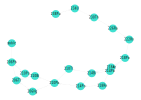

In [54]:
display_decay_chain("238Pu")

In [55]:
function power_of_entire_decay_chain(ancestor, time)
    chain = decay_chains[ancestor]
    power = 0
    isotope_list = [key for key in keys(chain) 
                    if !(key == "Parent" || is_last_step(chain[key]["Daughters"]))]
    push!(isotope_list, ancestor)
    for isotope in isotope_list
        if ancestor == isotope
            final_decay = chain["Parent"]
        else
            final_decay = chain[isotope]
        end
        power += power_per_mole(isotope, ancestor, final_decay, time)
    end
    return power
end

power_of_entire_decay_chain (generic function with 1 method)

TODO: Store the the energy by decay type (and the spectra) individually for each decay chain as a function of time. 

Now I will symbolically calculate the power generated by a decay chain represented as follows

In [56]:
example_decay_dict = Dict([])
E_0, E_1, E_2, p_0, p_1, p_2, t = @variables E_0, E_1, E_2, p_0, p_1, p_2, t
E_1b, p_1b, λ_1b = @variables E_1b, p_1b, λ_1b
example_decay_dict["Parent"] = Dict(["Energies (keV)" => [E_0], "e-fold (seconds)" => [λ_0], 
                            "Probabilities" => [p_0], "Daughters" => ["daughter0"]])
example_decay_dict["daughter0"] = Dict(["Energies (keV)" => [E_1, E_1b], 
                                "e-fold (seconds)" => [λ_1, λ_1b], 
                                "Probabilities" => [p_1, p_1b], 
                                "Daughters" => ["daughter1", "daughter1b"]])
example_decay_dict["daughter1"] = Dict(["Energies (keV)" => [E_2], "e-fold (seconds)" => [λ_2], 
                                "Probabilities" => [p_2], "Daughters" => ["daughter2"]])
example_decay_dict

Dict{Any, Any} with 3 entries:
  "daughter1" => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_2], "Probabilit…
  "Parent"    => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_0], "Probabilit…
  "daughter0" => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_1, λ_1b], "Prob…

In [57]:
decay_chains["test"] = example_decay_dict
decay_chains["test"]

Dict{Any, Any} with 3 entries:
  "daughter1" => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_2], "Probabilit…
  "Parent"    => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_0], "Probabilit…
  "daughter0" => Dict{String, Vector}("e-fold (seconds)"=>Num[λ_1, λ_1b], "Prob…

In [58]:
expected_output = (
    p_0 * (E_0 * exp(t / -λ_0) / λ_0 + 
        p_1 * ((1 - exp(t / -λ_1)) * E_1 * exp(t / -λ_0) / λ_0 + 
            p_2 * (1 - exp(t / -λ_1)) * (1 - exp(t / -λ_2)) * E_2 * exp(t / -λ_0) / λ_0
        ) + 
        p_1b * (1 - exp(t / -λ_1b)) * E_1b * exp(t / -λ_0) / λ_0
    )
)          

p_0*(p_1*((E_1*(1 - exp(t / (-λ_1)))*exp(t / (-λ_0))) / λ_0 + (E_2*p_2*(1 - exp(t / (-λ_1)))*(1 - exp(t / (-λ_2)))*exp(t / (-λ_0))) / λ_0) + (E_0*exp(t / (-λ_0))) / λ_0 + (E_1b*p_1b*(1 - exp(t / (-λ_1b)))*exp(t / (-λ_0))) / λ_0)

In [59]:
Test.@test Symbolics.simplify(power_of_entire_decay_chain("test", t) 
            - conversion_factor * expected_output) == 0

Test Passed
  Expression: Symbolics.simplify(power_of_entire_decay_chain("test", t) - conversion_factor * expected_output) == 0
   Evaluated: 0 == 0

In [60]:
pop!(decay_chains, "test")
decay_chains["63Ni"]

Dict{Any, Any} with 2 entries:
  "63Cu"   => Dict("Daughters"=>["stable"])
  "Parent" => Dict{String, Vector}("e-fold (seconds)"=>[4.60733e9], "Probabilit…

In [61]:
time_array = [BigFloat(10)^i for i in -10:.1:10]

201-element Vector{BigFloat}:
 1.000000000000000000000000000000000000000000000000000000000000000000000000000003e-10
 1.25892541179416618056939287182433126845996218444738646667433027351526766150798e-10
 1.584893192461110892181946192724010648088344291738932269688212001583469968929013e-10
 1.995262314968882865771422048142066754050560267675473740063769689274037024580373e-10
 2.511886431509582165915027997951851781486256187100727119702478521515105210922273e-10
 3.162277660168379331998893544432718533719555139325216826857504852792594438639243e-10
 3.981071705534969251016450836283920198412114190191191509354272293588653173320875e-10
 5.011872336272714650165832774680368447873261572716169180270627958838980964764036e-10
 6.309573444801942817342773037899355684778124488909748123578127485731705747260038e-10
 7.943282347242821518602174402167029674549522191888286138077973813312815371067055e-10
 1.000000000000000000000000000000000000000000000000000000000000000000000000000005e-09
 1.2589254117941661805693

In [62]:
ancestor_isotopes = [key for key in keys(decay_chains) 
                    if !is_last_step(decay_chains[key]["Parent"]["Daughters"])]
x = [power_of_entire_decay_chain(ancestor, 1) for ancestor in ancestor_isotopes]

2457-element Vector{Float64}:
      0.0
      1.4464494505846605e7
      2.600917973787413e10
      2.9738498610232815e10
      8.677318311261253e10
   3740.214202616102
      7.388317639697058e6
      3.360285734592206e7
 814015.4514913636
      3.030939766626044e10
      2.8292825030721133e6
      7.820841987842757e10
  17969.56800433875
      ⋮
   8453.789423121485
      0.0
      1.2280055196886765e10
      1.7221116200123395e11
      1.1542654282872071e9
      4.230554193358355e9
      3.0985872348209543e9
      1.8335219195760685e8
      2.2915321721233096e9
      4.3753233259083055e7
      7.4099416301163025e9
  14774.548544875857

In [63]:
isotope = "216Fr"
ancestor = "224Pa"
final_decay = decay_chains[ancestor][isotope]
power_per_mole(isotope, ancestor, final_decay, 1)

3.0017951850696454e11

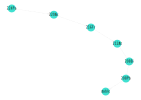

In [64]:
display_decay_chain("224Pa")

In [65]:
maximum(x), ancestor_isotopes[argmax(x)]

(1.0773017571778729e12, "224Pa")

It takes 3 seconds to simulate 1 time value for every decay chain I have data for. Thus it will take approximately 1 minute for every 20 time steps. 2001 time steps ran in 134 minutes. 

In [66]:
power_time_series = [[power_of_entire_decay_chain(isotope, time)
                        for time in time_array] for isotope in ancestor_isotopes]; 
power_time_series_dict = Dict([])
stop = length(power_time_series)
for i in 1:stop
        power_time_series_dict[ancestor_isotopes[i]] = power_time_series[i]
end
power_time_series_dict

Dict{Any, Any} with 2457 entries:
  "113Sn" => BigFloat[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0,…
  "243Cf" => BigFloat[1.44801e+07, 1.44801e+07, 1.44801e+07, 1.44801e+07, 1.448…
  "230Pu" => BigFloat[4.61985e+09, 4.61985e+09, 4.61985e+09, 4.61985e+09, 4.619…
  "106Nb" => BigFloat[2.17224e+11, 2.17224e+11, 2.17224e+11, 2.17224e+11, 2.172…
  "168Eu" => BigFloat[7.24963e+11, 7.24963e+11, 7.24963e+11, 7.24963e+11, 7.249…
  "18Ne"  => BigFloat[5.99651e+10, 5.99651e+10, 5.99651e+10, 5.99651e+10, 5.996…
  "75Cu"  => BigFloat[1.46871e+11, 1.46871e+11, 1.46871e+11, 1.46871e+11, 1.468…
  "162Sm" => BigFloat[3.85388e+10, 3.85388e+10, 3.85388e+10, 3.85388e+10, 3.853…
  "57V"   => BigFloat[7.43792e+11, 7.43792e+11, 7.43792e+11, 7.43792e+11, 7.437…
  "208Po" => BigFloat[3740.21, 3740.21, 3740.21, 3740.21, 3740.21, 3740.21, 374…
  "222Pa" => BigFloat[9.75018e+13, 9.75018e+13, 9.75018e+13, 9.75018e+13, 9.750…
  "174Ir" => BigFloat[1.04932e+06, 1.04932e+06, 1.04932e+06, 1.04932e+06, 1

In [67]:
power_matrix = Matrix{Union{Float64, BigFloat, Int64}}(undef, stop, length(time_array))
for row in 1:stop
    power_matrix[row, :] = power_time_series_dict[ancestor_isotopes[row]]
end
power_df = DataFrame(power_matrix, string.(time_array))

,1.000000000000000000000000000000000000000000000000000000000000000000000000000003e-10
,Union…
1,0.0
2,1.448011974325501348386999989813504293787527843804040683683944261058435132717739e+07
3,7.249633292054007246720920765094881293122669042286549707840698313624233146154068e+11
4,3.853875632674555958658427628817897047161779472341905197275781097056861519148182e+10
5,7.437917271028484003105909170080619042933438503858967839184469667931434307961673e+11
6,3740.214230964521594707266511637938016699156566810777337670589114861215500564882
7,1.049315763771079440971184622919073946135066680381760267228277460594719575661113e+06
8,0.003484748401770615148704758599019514406799498176008992995549476550745051560187094
9,375182.5048195058572735873330274084234950009597068444032893047416861841954915475


In [68]:
power_df[!, "Parent Isotope"] = ancestor_isotopes

2457-element Vector{String}:
 "113Sn"
 "243Cf"
 "168Eu"
 "162Sm"
 "57V"
 "208Po"
 "174Ir"
 "144Gd"
 "80Sr"
 "33Ar"
 "108In"
 "252No"
 "254Es"
 ⋮
 "217At"
 "216Fr"
 "25Al"
 "194Po"
 "229Fr"
 "208Ac"
 "81As"
 "70Fe"
 "18C"
 "184Tl"
 "240Cf"
 "133Xe"

In [69]:
CSV.write(cross_section_dir * "Corrected_power_time_series_201_steps.csv", power_df)

"C:\\Cross-Section-Data\\Corrected_power_time_series_201_steps.csv"

In [70]:
function plot_power_time_series(nuclide, time_array)
    power_time_series = Float64.(power_time_series_dict[nuclide])
    time_array = Float64.(time_array)
    plot(scatter(x = time_array, y = power_time_series, mode = "markers"), 
    Layout(xaxis_type = "log", yaxis_type = "log"))#, yaxis_type = "log"))
end
plot_power_time_series("238Pu", time_array)

data: [
  "scatter with fields mode, type, x, and y"
]

layout: "layout with fields margin, template, xaxis, and yaxis"

The specific power of plutonium is correctly predicted here sine this is a plot of power per mole :) 

In [202]:
132/ 238

0.5546218487394958

Now to find the highest power decay chain as a function of time. 

In [196]:
str_time_array = string.(time_array)
max_power_isotopes = [ancestor_isotopes[argmax(power_df[!, t])]
                    for t in str_time_array]
max_power_values = [power_df[argmax(power_df[!, t]), t] for t in str_time_array]

2001-element Vector{BigFloat}:
  1.224533664518007127219176304516863239638269840640661176124314988674446620303449e+19
  1.224497052715167633736354798281782365897940043065159542764830530745769230480374e+19
  1.22445958924707055732864572588652472996526139892437561058486462618922852013492e+19
  1.224421254329252602836468130534012947637522061940571711535021242217056310850111e+19
  1.224382027718923730947172027203810583706340202281353315129349485720471729685097e+19
  1.224341888704409579648615535117120197220360001522518818014814608186059817207882e+19
  1.224300816094353562899360408207771977455634371793138213674063476357048499970801e+19
  1.224258788206673201520158206768497763285665630647246646198158883158317975397716e+19
  1.224215782857265379153329246245557536409750253103780607242125266977056140789673e+19
  1.224171777348454852884115336661492881320878860055160912343894958379680816670924e+19
  1.22412674845718038090589678512808880606870894135978015876259037519834244611712e+19
  1.2240806724

In [197]:
max_power_df = DataFrame(Time_seconds = time_array, Power_watts = max_power_values,
Isotope = max_power_isotopes, stringtype = string)

,Time_seconds
,BigFloat
1,1.000000000000000000000000000000000000000000000000000000000000000000000000000003e-10
2,1.023292992280753628707946425470586449836162000188265018759950905665043083135048e-10
3,1.047128548050898505549645783823682271757193893433574137820153812424537637016191e-10
4,1.071519305237604839621198635362801041238260239703671722608804514470749620005072e-10
5,1.0964781961431828604257317209264159331313714105011702911985913060102831306613e-10
6,1.122018454301965271308726629737566563801751522818999506694325849457920023841529e-10
7,1.148153621496884066480156540139268838588675605873626387416861363160599339507005e-10
8,1.17489755493953031061502653917700540529463859186872890540168646534725478209488e-10
9,1.202264434617413102533306847068551134853580025789314084263608408653746937282328e-10


In [199]:
plot(scatter(max_power_df, x=:Time_seconds, y=:Power_watts, mode="markers",
                text=:Isotope, color=:Isotope),
    Layout(xaxis_type = "log", yaxis_type = "log", show_scale = true))

data: [
  "scatter with fields color, mode, text, type, x, and y"
]

layout: "layout with fields margin, show, template, xaxis, and yaxis"

In [198]:
unique(max_power_df[!,"Isotope"])

34-element Vector{String}:
 "219Pa"
 "217Ac"
 "215Fr"
 "218Th"
 "212Po"
 "214At"
 "216Fr"
 "215At"
 "217Th"
 "218Fr"
 "222Th"
 "26F"
 "220Ac"
 ⋮
 "226Th"
 "227Pa"
 "254Fm"
 "226Ac"
 "224Ra"
 "223Ra"
 "230U"
 "257Fm"
 "228Th"
 "228Ra"
 "227Ac"
 "232U"